In [273]:
from data_describe.core import time
from google.cloud import storage
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import subprocess
import sys
from google.cloud import storage

In [276]:
def run_dd(gcs_root, file):
    #data_loc = "gs://{0}/{1}".format(bucket, file)
    data_loc = "{0}/{1}".format(gcs_root, file)
    data = pd.read_csv(data_loc, index_col=0)
    data.index = pd.to_datetime(data.index)
    
    def save_to_gcs(job_dir, folder, filename):
        gcs_path = "{0}/{1}/{2}".format(job_dir, folder, filename)
        #subprocess.check_call(['gsutil', 'cp', filename, gcs_path], stderr=sys.stdout)
        subprocess.check_call(['gsutil', 'cp', filename, gcs_path])
        
    # Decomposition plots
    fig, ax = plt.subplots(4, figsize=(14, 6), dpi=80)    
    decompose=[]
    for idx, item in enumerate(data.columns):
        decompose.append(seasonal_decompose(data[item], model='additive', period=100))
        ax[0].set_title('T=100')
        ax[0].plot(decompose[idx].observed)
        ax[0].set(ylabel='observed')
        ax[1].plot(decompose[idx].trend)
        ax[1].set(ylabel='trend')
        ax[2].plot(decompose[idx].seasonal)
        ax[2].set(ylabel='seasonal')
        ax[3].plot(decompose[idx].resid)
        ax[3].set(ylabel='resid')
        
    decompose_filename = "decompose.png"
    fig.savefig(decompose_filename)
    save_to_gcs(gcs_root, 'datadescribe', decompose_filename)
    
    # Stationarity Test
    fig, ax = plt.subplots(4, figsize=(14, 6), dpi=80)  
    for idx, item in enumerate(data.columns):
        stationarity = time.stationarity_test(data, col=data.columns.tolist()[idx], test='dickey-fuller')
        stationarity_filename = 'stationarity_{0}.csv'.format(item)
        stationarity.to_csv(stationarity_filename)
        save_to_gcs(gcs_root, 'datadescribe', stationarity_filename)
    
        # Plot Autocorrelation
        acf = time.plot_autocorrelation(data, col=data.columns.tolist()[idx], plot_type='acf', fft=True, n_lags=100)
        acf.suptitle('ACF_{0}'.format(item))
        acf_filename = "acf_{0}.png".format(item)
        acf.savefig(acf_filename)
        save_to_gcs(gcs_root, 'datadescribe', acf_filename)
        
        # Plot Partial Autocorrelation
        pacf = time.plot_autocorrelation(data, col=data.columns.tolist()[idx], plot_type='pacf', fft=True, n_lags=100)
        pacf.suptitle('PACF_{0}'.format(item))
        pacf_filename = "pacf_{0}.png".format(item)
        pacf.savefig(pacf_filename)
        save_to_gcs(gcs_root, 'datadescribe', pacf_filename)
    
        

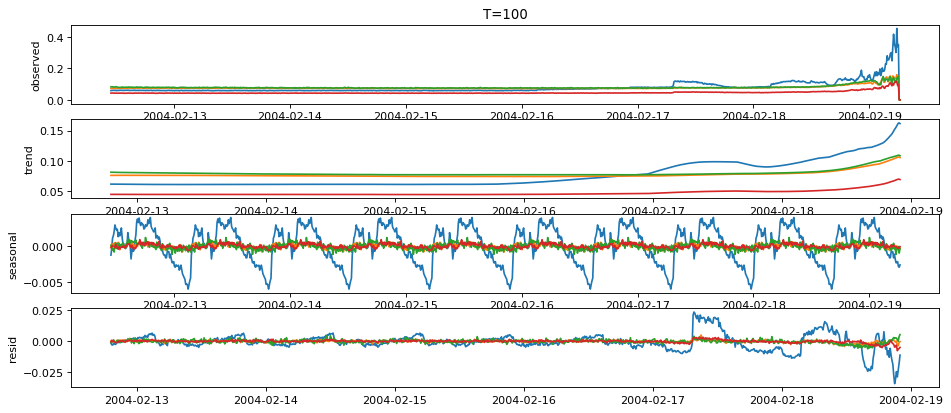

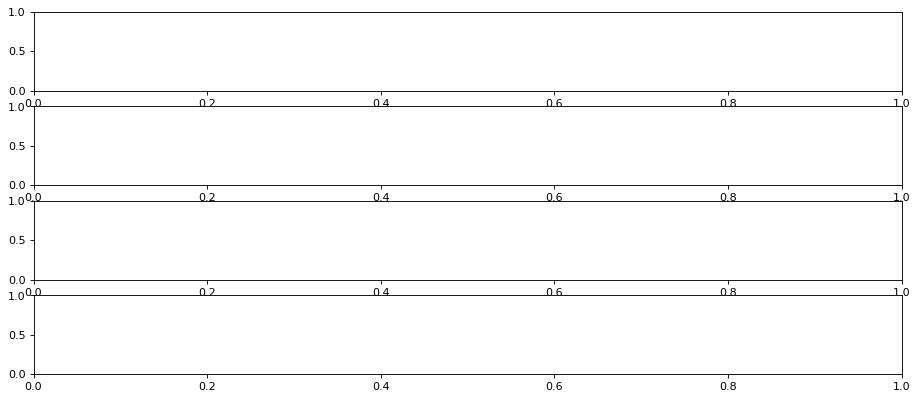

In [277]:
bucket = 'rrusson-kubeflow-test'
file = 'raw_data_v5.csv'
gcs_root="gs://rrusson-kubeflow-test"
run_dd(gcs_root, file)

In [234]:
#!gsutil cp 'decompose.png' 'gs://rrusson-kubeflow-test/datadescribe/decompose.png'

Copying file://decompose.png [Content-Type=image/png]...
/ [1 files][107.3 KiB/107.3 KiB]                                                
Operation completed over 1 objects/107.3 KiB.                                    
